## Лабораторная работа "Задача Коши"

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import threading as thr

In [89]:
class SetFunc:
    def __init__(self, a, b, h, dim=1):
        self.dim = dim
        self.n = int((b - a) / h)
        self.n += (self.n % 2 == 0)

        self.a = a
        self.b = a + h * (self.n - 1)
        self.h = h

        self.x = np.zeros(self.n)
        for i in range(self.n):
            self.x[i] = a + self.h * i

        if self.dim == 0:
            self.y = [[0]] * self.n
        elif self.dim == 1:
            self.y = np.zeros(self.n)
        else:
            np_list = []
            for i in range(self.n):
                np_list.append(np.zeros(self.dim))
            self.y = np.asarray(np_list)

    def sol(self, func, de=False):
        self.f = func
        for i in range(self.x.size):
            self.y[i] = func(self.x[i])

    def plot(self, axes='01', marker='', label='', title_str='', figsize=(9, 6), new=True, ext_plt='', external=False):
        if new and not external:
            fig, self.ax = plt.subplots(figsize=figsize)
            self.ax.set(xlabel='x', ylabel='y', title=title_str)
            self.ax.grid()

        if external:
            self.ax = ext_plt

        if self.dim == 0:
            x = []
            y = []
            for i in range(self.n):
                for j in range(len(self.y[i])):
                    x.append(self.x[i])
                    y.append(self.y[i][j])

            if label == '':
                self.ax.scatter(x, y, s=0.3)
            else:
                self.ax.scatter(x, y, s=0.3, label=label)
                self.ax.legend()
        else:
            x = self.x
            if axes[0] != '0':
                x = self.y
                if self.dim != 1:
                    x = np.split(self.y, self.dim, axis=1)[int(axes[0]) - 1]

            y = self.x
            if axes[1] != '0':
                y = self.y
                if self.dim != 1:
                    y = np.split(self.y, self.dim, axis=1)[int(axes[1]) - 1]

            if label == '':
                self.ax.plot(x, y, marker)
            else:
                self.ax.plot(x, y, marker, label = label)
                self.ax.legend()

def retx(t):
    return 1 * (np.cos(2*t) - np.sin(2*t)) - 2 * 2 * np.sin(2*t)

def rety(t):
    return 1 * np.sin(2*t) + 2 * (np.cos(2*t) + np.sin(2*t))

In [90]:
class Graph(SetFunc):
    def __init__(self, begin_h, end_h, step_h, true_x, dx, name):
        super().__init__(begin_h, end_h, step_h)
        self.dx = dx
        self.name = name
        self.true_x = true_x

    def plot(self, title_str = ''):
        super().plot(title_str = title_str)
        self.ax.set(xlabel='ln(h)', ylabel='ln(Eps)', title = self.name)
        k, b = np.polyfit(self.x, self.y, 1)
        print(k)
        #self.ax.legend()

    def sol(self, a, b, x0, method, logarithm = False, dim = 1):
        for i in range(self.n):
            grid_sol_x = SetFunc(a, b, self.x[i], dim)
            grid_sol_x.y[0] = x0
            method(grid_sol_x, self.dx)

            grid_true_x = SetFunc(a, b, self.x[i], dim)
            grid_true_x.sol(self.true_x)

            self.y[i] = np.amax(np.absolute(grid_sol_x.y[-1] - grid_true_x.y[-1]))
            if logarithm:
                self.x[i] = m.log(self.x[i])
                self.y[i] = m.log(self.y[i])



In [91]:
def system(t, u):
    x, y = u
    dxdt = -2*x - 4*y
    dydt = 2*x + 2*y
    return np.array([dxdt, dydt])

def neyavnEuler(setF, f):
    for i in range(1, setF.n):
        setF.y[i] = setF.y[i - 1] + setF.h * f(setF.y[i - 1], setF.x[i - 1])

def yavnEuler(setF, f):
    for i in range(1, setF.n):
        setF.y[i] = np.array([-2 * setF.y[i - 1][0] * setF.h + setF.y[i - 1][0] - 4 * setF.y[i - 1][1] * setF.h,
                            2 * setF.y[i - 1][0] * setF.h + 2 * setF.y[i - 1][1] * setF.h + setF.y[i - 1][1]]) / (4 * setF.h ** 2 + 1)


def trap(setF, f):
    for i in range(1, setF.n):
        a = setF.y[i - 1][0] * (1 - setF.h) - 2 * setF.y[i - 1][1] * setF.h
        b = setF.y[i - 1][1] * (1 + setF.h) + setF.y[i - 1][0] * setF.h
        setF.y[i] = np.array([-a * setF.h + a - 2 * b * setF.h,
                            a * setF.h + b * setF.h + b]) / (setF.h ** 2 + 1)

def RG4(setF, f):
    for i in range(1, setF.n):
        k1 = f(setF.y[i - 1], setF.x[i - 1])
        k2 = f(setF.y[i - 1] + setF.h * k1 / 2, setF.x[i - 1] + setF.h / 2)
        k3 = f(setF.y[i - 1] + setF.h * k2 / 2, setF.x[i - 1] + setF.h / 2)
        k4 = f(setF.y[i - 1] + setF.h * k3, setF.x[i - 1] + setF.h)
        setF.y[i] = setF.y[i - 1] + setF.h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

sist  = lambda x, t: np.array([-2 * x[0] - 4 * x[1],
                                2 * x[0] + 2 * x[1]])

resh = lambda t, c: np.array([c[0] * (m.cos(2 * t) - m.sin(2 * t)) - 2 * c[1] * m.sin(2 * t),
                                c[0] * m.sin(2 * t) + c[1] * (m.cos(2 * t) + m.sin(2 * t))])

def start(begin_h, end_h, step_h, x0, t0, method, name):
    a = t0; b = a + 1

    c = np.array([x0[0] * (m.cos(2 * t0) + m.sin(2 * t0)) + 2 * x0[1] * m.sin(2 * t0),
                  x0[1] * (m.cos(2 * t0) - m.sin(2 * t0)) - x0[0] * m.sin(2 * t0)])

    nach = lambda t: resh(t, c)
    
    le = Graph(begin_h, end_h, step_h, nach, sist, name)
    le.sol(a, b, x0, method, True, 2)
    le.plot()
    plt.show()

1.0037299766540682


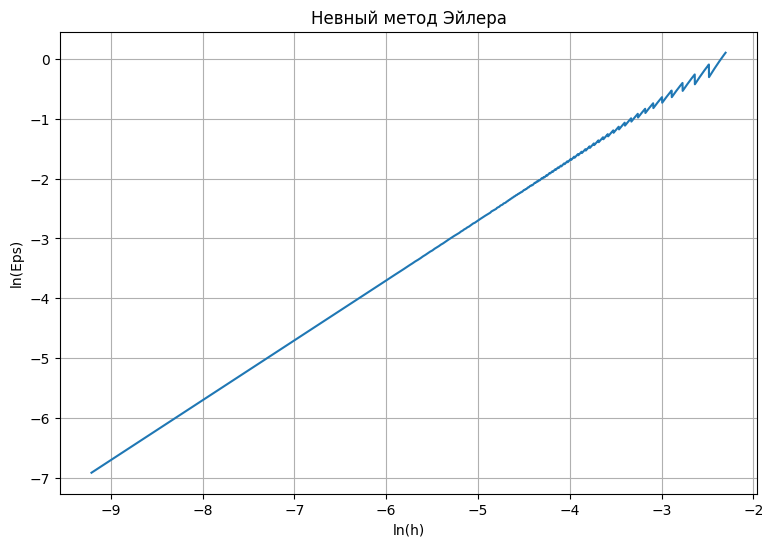

0.9523156113501967


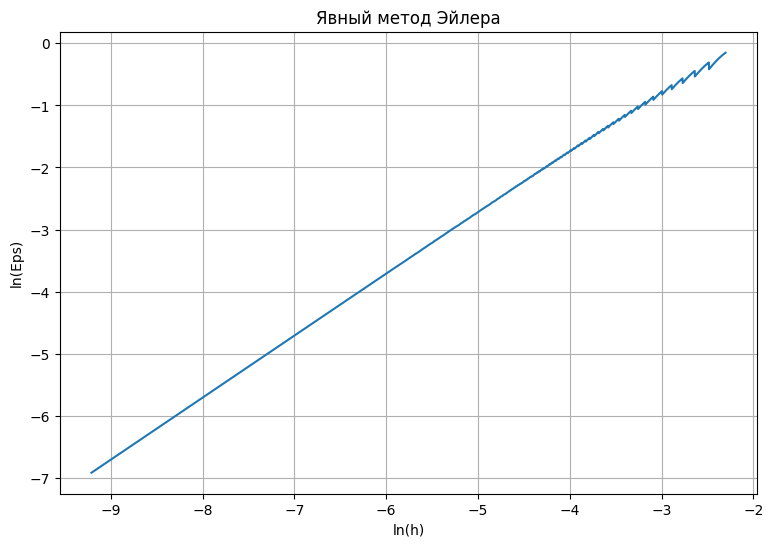

1.9393299602133107


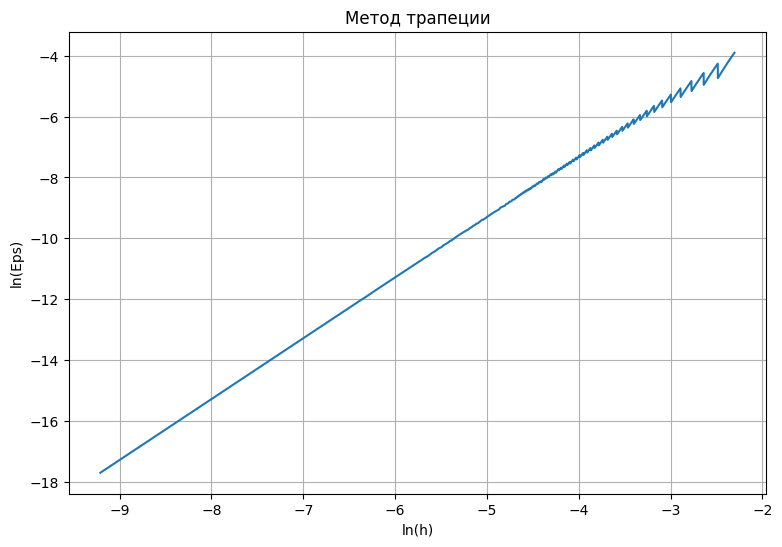

4.040382273249507


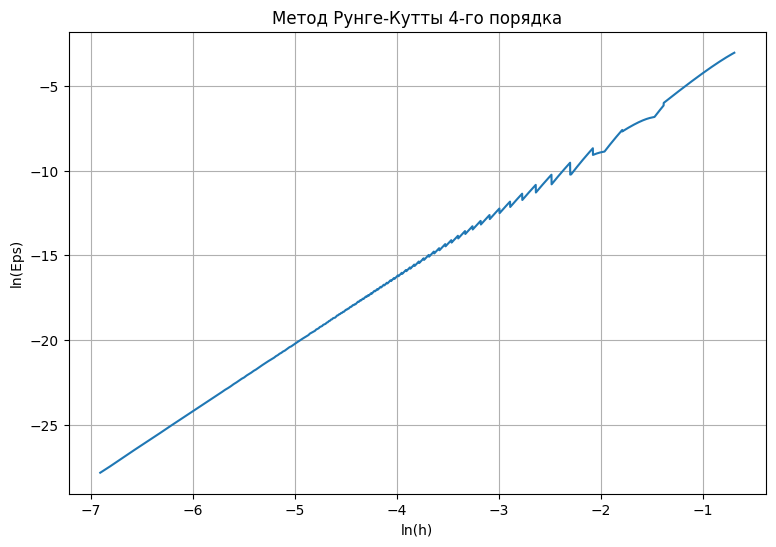

In [92]:
start(0.0001, 0.1, 0.0001, np.array([1, 2]), 0, neyavnEuler, 'Невный метод Эйлера')
start(0.0001, 0.1, 0.0001, np.array([1, 2]), 0, yavnEuler, 'Явный метод Эйлера')
start(0.0001, 0.1, 0.0001, np.array([1, 2]), 0, trap, 'Метод трапеции')
start(0.001, 0.5, 0.0001, np.array([1, 2]), 0, RG4, 'Метод Рунге-Кутты 4-го порядка')

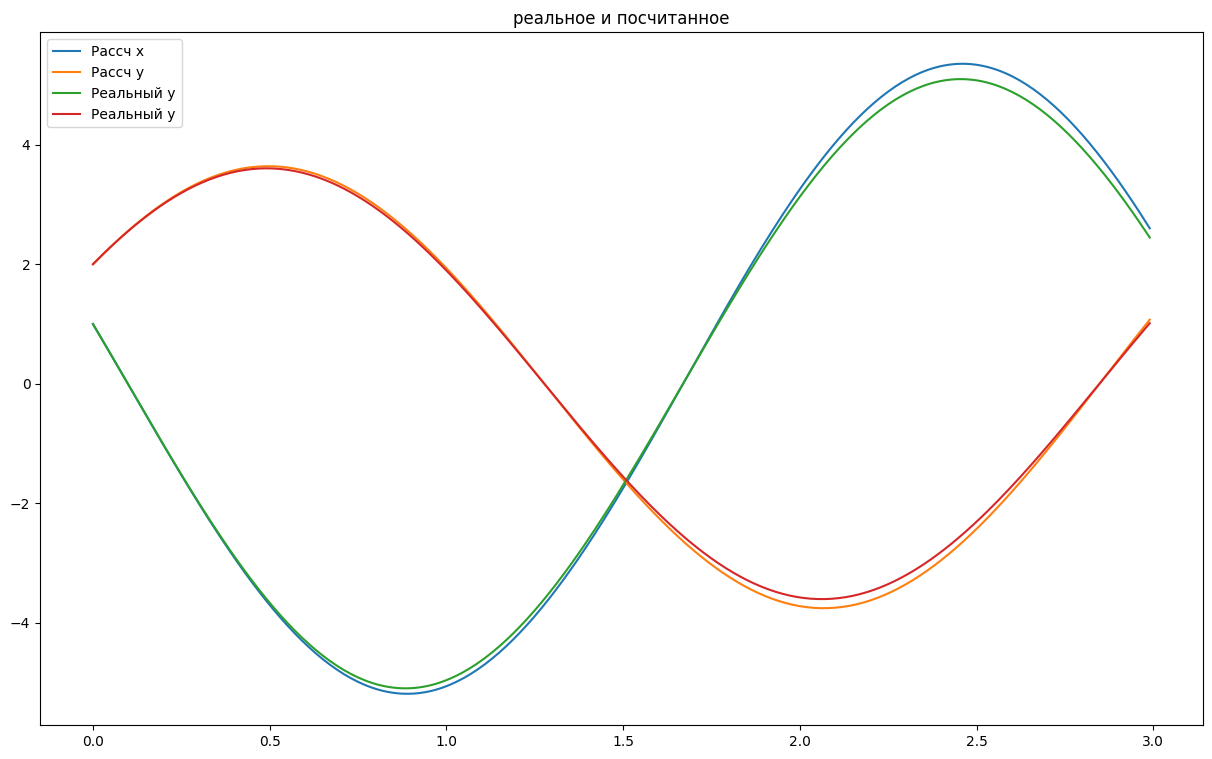

In [95]:
def eV(func, u0, tlist, h):
    u_values = [u0]
    for t in tlist[:-1]:
        u_next = u_values[-1] + h * func(t, u_values[-1])
        u_values.append(u_next)
    return np.array(u_values)

tlist = np.arange(0, 3, 0.01)

rassch = eV(system, [1, 2], tlist, 0.01)

rx = retx(tlist)
ry = rety(tlist)

plt.figure(figsize=(15, 9))
plt.plot(tlist, rassch[:, 0], label='Рассч х')
plt.plot(tlist, rassch[:, 1], label='Рассч у')
plt.plot(tlist, rx, label='Реальный у')
plt.plot(tlist, ry, label='Реальный у')
plt.title('реальное и посчитанное')
plt.legend(loc='best')
plt.show()